## **1. Paramètres**

In [1]:
# Importation des bibliothèques
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import rasterio
from rasterio import features
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy import ndimage

In [2]:
# Définition des chemins de sortie
partial_output_path = '../data_brut/2_rasters'
final_output_path = '../data_final'

# Vérifier et créer les répertoires
if not os.path.exists(partial_output_path):
    os.makedirs(partial_output_path)

if not os.path.exists(final_output_path):
    os.makedirs(final_output_path)  


In [3]:
# Chargement des données
path_bd = "../data_brut/bd_tls.gpkg"
layers = fiona.listlayers(path_bd)

# Afficher la liste des couches
print("Couches disponibles dans le fichier GeoPackage :")
for layer in layers:
    print(layer)

Couches disponibles dans le fichier GeoPackage :
lieu_dit_non_habite
adresse_ban
aerodrome
batiment
canalisation
cimetiere
commune
construction_lineaire
construction_surfacique
cours_d_eau
departement
equipement_de_transport
foret_publique
ligne_electrique
parc_ou_reserve
piste_d_aerodrome
plan_d_eau
region
reservoir
route_numerotee_ou_nommee
surface_hydrographique
terrain_de_sport
toponymie_lieux_nommes
toponymie_zones_reglementees
transport_par_cable
troncon_de_route
troncon_de_voie_ferree
troncon_hydrographique
voie_nommee
zone_d_activite_ou_d_interet
zone_d_habitation
zone_de_vegetation
toulouse_metropole
insee_carreaux_200m
route_cyclabe_geovelo
iris_pop_diplomes
bio_markets
iris_csp
centroides_zones
layer_styles


In [4]:
# Charger les carreaux INSEE et créer une copie du GeoDataFrame 
carreaux_insee = gpd.read_file(path_bd, layer='insee_carreaux_200m')
carreaux_insee = carreaux_insee.copy() 

# Charger le périmètre de Toulouse Métropole
tls_mtp = gpd.read_file(path_bd, layer='toulouse_metropole')

# Vérifier les données
print(carreaux_insee.columns)

Index(['idcar_200m', 'idcar_1km', 'idcar_nat', 'i_est_200', 'i_est_1km',
       'lcog_geo', 'ind', 'men', 'men_pauv', 'men_1ind', 'men_5ind',
       'men_prop', 'men_fmp', 'ind_snv', 'men_surf', 'men_coll', 'men_mais',
       'log_av45', 'log_45_70', 'log_70_90', 'log_ap90', 'log_inc', 'log_soc',
       'ind_0_3', 'ind_4_5', 'ind_6_10', 'ind_11_17', 'ind_18_24', 'ind_25_39',
       'ind_40_54', 'ind_55_64', 'ind_65_79', 'ind_80p', 'ind_inc',
       'geometry'],
      dtype='object')


## **2. Âge**

In [5]:
# Calculer les tranches d'âge définies
# On regroupe les individus en trois tranches d'âge :
# 1. 18-39 ans (somme des individus de 18-24 ans et de 25-39 ans)
# 2. 40-64 ans (somme des individus de 40-54 ans et de 55-64 ans)
# 3. 65 ans et plus (somme des individus de 65-79 ans et de plus de 80 ans)
carreaux_insee.loc[:, 'age_18_39'] = carreaux_insee['ind_18_24'] + carreaux_insee['ind_25_39']
carreaux_insee.loc[:, 'age_40_64'] = carreaux_insee['ind_40_54'] + carreaux_insee['ind_55_64']
carreaux_insee.loc[:, 'age_65p'] = carreaux_insee['ind_65_79'] + carreaux_insee['ind_80p']

# Appliquer les pourcentages moyens pour estimer les consommateurs bio potentiels par tranche d'âge
# Chaque tranche d'âge a un pourcentage associé à la consommation bio.
# Par exemple : 35.5% des 18-39 ans sont des consommateurs bio potentiels.
carreaux_insee.loc[:, 'potentiel_age'] = (
    carreaux_insee['age_18_39'] * 0.355 +   # Pourcentage pour la tranche 18-39 ans
    carreaux_insee['age_40_64'] * 0.285 +   # Pourcentage pour la tranche 40-64 ans
    carreaux_insee['age_65p'] * 0.285       # Pourcentage pour la tranche 65 ans et plus
)

# Sélectionner les colonnes pertinentes et créer un nouveau GeoDataFrame avec
# les informations sur l'âge, l'individu et le potentiel bio selon l'âge.
colonnes_age_calc = ['idcar_200m', 'ind', 'potentiel_age', 'geometry']
carreaux_age = carreaux_insee[colonnes_age_calc]

# Vérifier la nouvelle structure du GeoDataFrame pour s'assurer que les colonnes sont correctes
print(carreaux_age.columns)
print(carreaux_age.head())


Index(['idcar_200m', 'ind', 'potentiel_age', 'geometry'], dtype='object')
                       idcar_200m   ind  potentiel_age  \
0  CRS3035RES200mN2307400E3638400  28.0         7.3360   
1  CRS3035RES200mN2307600E3638000  18.0         4.7105   
2  CRS3035RES200mN2307600E3638200  13.0         3.4225   
3  CRS3035RES200mN2307600E3638400   7.0         1.8500   
4  CRS3035RES200mN2307800E3620800   5.0         1.2310   

                                            geometry  
0  POLYGON ((583344.843 6271080.255, 583327.379 6...  
1  POLYGON ((582929.383 6271241.963, 582911.919 6...  
2  POLYGON ((583128.381 6271260.861, 583110.917 6...  
3  POLYGON ((583327.379 6271279.758, 583309.915 6...  
4  POLYGON ((565797.429 6269814.926, 565779.974 6...  


### **2.1 Plotter âge**

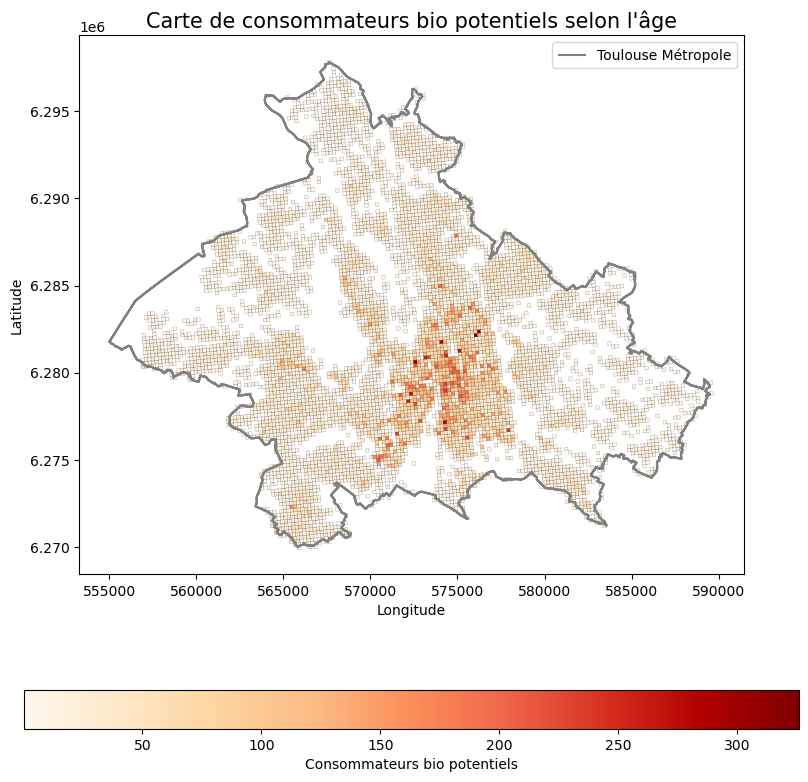

In [6]:
# Créer une figure et des axes
fig, ax = plt.subplots(figsize=(10, 10))

# Tracer les carreaux INSEE avec le score bio_potentiel_age
carte_heatmap = carreaux_age.plot(column='potentiel_age', ax=ax, cmap='OrRd', legend=True, 
                                  legend_kwds={'label': "Consommateurs bio potentiels", 'orientation': "horizontal"},
                                  edgecolor='black', linewidth=0.1)

# Superposer le périmètre de Toulouse Métropole
tls_mtp.boundary.plot(ax=ax, color='grey', linewidth=1.5, label='Toulouse Métropole')

# Ajouter un titre et ajuster l'affichage
plt.title("Carte de consommateurs bio potentiels selon l'âge", fontsize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Afficher la légende et la carte
plt.legend(loc='upper right')
plt.show()



## **3. Revenus**

In [7]:
# Calculer le revenu annuel moyen par individu
# On divise la somme des revenus (ind_snv) par le nombre d'individus (ind) pour obtenir
# le revenu annuel moyen. Si le nombre d'individus est supérieur à 0, on fait la division,
# sinon on retourne None pour éviter une division par zéro.
carreaux_insee.loc[:, 'revenu_annuel_moyen'] = carreaux_insee.apply(
    lambda row: row['ind_snv'] / row['ind'] if row['ind'] > 0 else None, axis=1
)

# Convertir le revenu annuel en revenu mensuel
# Le revenu annuel moyen est divisé par 12 pour obtenir le revenu mensuel moyen par individu.
carreaux_insee.loc[:, 'revenu_mensuel_moyen'] = carreaux_insee['revenu_annuel_moyen'] / 12

# Fonction pour calculer le potentiel de consommateurs bio selon le revenu
# Cette fonction prend la population dans chaque carreau et applique un pourcentage
# basé sur la gamme de revenu mensuel moyen.
def calculer_potentiel_revenu(row):
    pct = {
        'gamme_1': 0.23,  # Revenu < 1000
        'gamme_2': 0.28,  # 1000 <= revenu < 1500
        'gamme_3': 0.32,  # 1500 <= revenu < 2000
        'gamme_4': 0.38,  # 2000 <= revenu < 2500
        'gamme_5': 0.42   # Revenu > 2500
    }
    # Appliquer les multiplicateurs en fonction de la gamme de revenu mensuel
    revenu_mensuel = row['revenu_mensuel_moyen']
    population = row['ind']
    
    # Calculer le nombre de consommateurs potentiels selon le revenu
    # en appliquant le pourcentage de consommateurs bio à la population totale.
    if revenu_mensuel < 1000:
        return population * pct['gamme_1']
    elif 1000 <= revenu_mensuel < 1500:
        return population * pct['gamme_2']
    elif 1500 <= revenu_mensuel < 2000:
        return population * pct['gamme_3']
    elif 2000 <= revenu_mensuel < 2500:
        return population * pct['gamme_4']
    else:
        return population * pct['gamme_5']

# Appliquer la fonction pour obtenir le nombre de consommateurs bio potentiels
# selon les revenus pour chaque carreau INSEE. Cela crée une nouvelle colonne 'potentiel_revenu_abs'
# avec les valeurs absolues (avant la normalisation).
carreaux_insee.loc[:, 'potentiel_revenu'] = carreaux_insee.apply(calculer_potentiel_revenu, axis=1)

# Sélectionner les colonnes importantes et créer un nouveau GeoDataFrame avec
# les informations sur le revenu, l'individu et le potentiel bio selon le revenu.
colonnes_revenu_calc = ['idcar_200m', 'ind', 'potentiel_revenu', 'geometry']
carreaux_revenu = carreaux_insee[colonnes_revenu_calc]

# Vérifier la structure du nouveau GeoDataFrame pour s'assurer que les colonnes sont correctes
print(carreaux_revenu.columns)
print(carreaux_revenu.head())


Index(['idcar_200m', 'ind', 'potentiel_revenu', 'geometry'], dtype='object')
                       idcar_200m   ind  potentiel_revenu  \
0  CRS3035RES200mN2307400E3638400  28.0             11.76   
1  CRS3035RES200mN2307600E3638000  18.0              7.56   
2  CRS3035RES200mN2307600E3638200  13.0              5.46   
3  CRS3035RES200mN2307600E3638400   7.0              2.94   
4  CRS3035RES200mN2307800E3620800   5.0              2.10   

                                            geometry  
0  POLYGON ((583344.843 6271080.255, 583327.379 6...  
1  POLYGON ((582929.383 6271241.963, 582911.919 6...  
2  POLYGON ((583128.381 6271260.861, 583110.917 6...  
3  POLYGON ((583327.379 6271279.758, 583309.915 6...  
4  POLYGON ((565797.429 6269814.926, 565779.974 6...  


### **3.1 Plotter revenu**

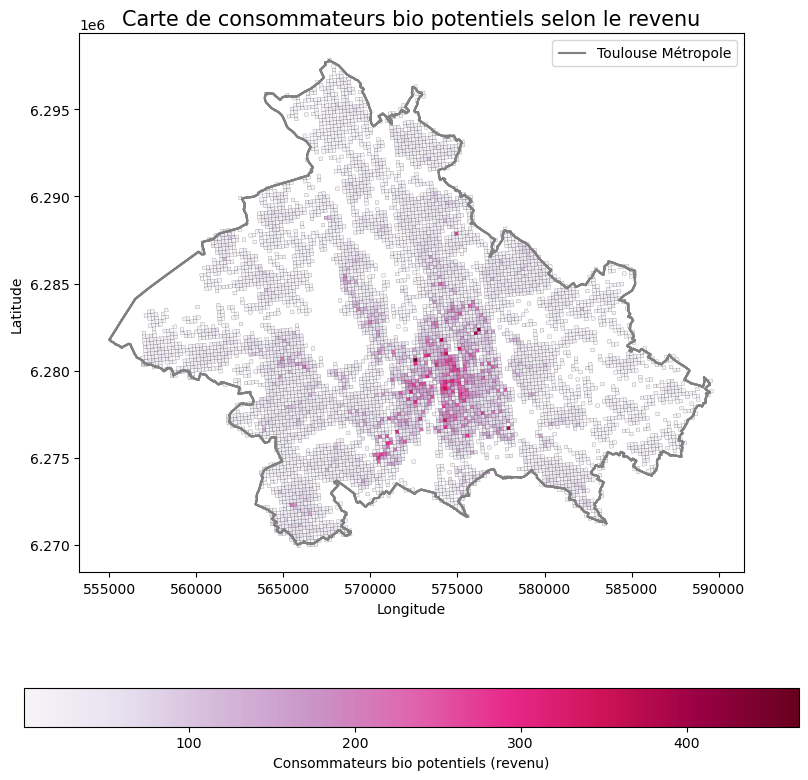

In [8]:
# Créer une figure et des axes
fig, ax = plt.subplots(figsize=(10, 10))

# Tracer les carreaux INSEE avec le potentiel bio basé sur le revenu
carte_heatmap_revenu = carreaux_revenu.plot(column='potentiel_revenu', ax=ax, cmap='PuRd', legend=True, 
                                            legend_kwds={'label': "Consommateurs bio potentiels (revenu)", 
                                                         'orientation': "horizontal"},
                                            edgecolor='black', linewidth=0.1)

# Superposer le périmètre de Toulouse Métropole
tls_mtp.boundary.plot(ax=ax, color='grey', linewidth=1.5, label='Toulouse Métropole')

# Ajouter un titre et ajuster l'affichage
plt.title("Carte de consommateurs bio potentiels selon le revenu", fontsize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Afficher la légende et la carte
plt.legend(loc='upper right')
plt.show()



## **4. Diplômes**

In [9]:
# Charger les IRIS avec l'information sur les diplômes
iris_diplome_brut = gpd.read_file(path_bd, layer='iris_pop_diplomes')

# Vérifier les données
print(iris_diplome_brut.columns)

Index(['ID', 'INSEE_COM', 'NOM_COM', 'IRIS', 'CODE_IRIS', 'NOM_IRIS',
       'TYP_IRIS', 'P20_NSCOL15P_DIPLMIN', 'P20_NSCOL15P_BEPC',
       'P20_NSCOL15P_CAPBEP', 'P20_NSCOL15P_BAC', 'P20_NSCOL15P_SUP2',
       'P20_NSCOL15P_SUP34', 'P20_NSCOL15P_SUP5', 'geometry'],
      dtype='object')


In [10]:
# Agréger les différents diplômes selon le rapport
# Nous combinons les catégories de diplômes dans des groupes plus larges :
# 1. 'sansdip_cep_bepc' combine les individus sans diplôme (DIPL_MIN) et ceux ayant un BEPC
# 2. 'cap_bep' regroupe les individus ayant un CAP ou BEP
# 3. 'bac' correspond aux individus ayant obtenu un Baccalauréat
# 4. 'bac2_bac3_bac4' combine les individus avec des diplômes BAC+2, BAC+3 et BAC+4
# 5. 'bac5p' correspond aux individus ayant un BAC+5 ou plus
iris_diplome_brut.loc[:, 'sansdip_cep_bepc'] = iris_diplome_brut['P20_NSCOL15P_DIPLMIN'] + iris_diplome_brut['P20_NSCOL15P_BEPC']
iris_diplome_brut.loc[:, 'cap_bep'] = iris_diplome_brut['P20_NSCOL15P_CAPBEP']
iris_diplome_brut.loc[:, 'bac'] = iris_diplome_brut['P20_NSCOL15P_BAC']
iris_diplome_brut.loc[:, 'bac2_bac3_bac4'] = iris_diplome_brut['P20_NSCOL15P_SUP2'] + iris_diplome_brut['P20_NSCOL15P_SUP34']
iris_diplome_brut.loc[:, 'bac5p'] = iris_diplome_brut['P20_NSCOL15P_SUP5']

# Faire la sommme de toute la population avec et sans diplome
iris_diplome_brut['total_diplome'] = (
    iris_diplome_brut['sansdip_cep_bepc'] + 
    iris_diplome_brut['cap_bep'] + 
    iris_diplome_brut['bac'] + 
    iris_diplome_brut['bac2_bac3_bac4'] + 
    iris_diplome_brut['bac5p']
)

# Calculer le pourcentange de personnes diplômes dans chaque catégorie
iris_diplome_brut.loc[:, 'pct_sansdip_cep_bepc'] = iris_diplome_brut['sansdip_cep_bepc'] / iris_diplome_brut['total_diplome'] * 100
iris_diplome_brut.loc[:, 'pct_cap_bep'] = iris_diplome_brut['cap_bep'] / iris_diplome_brut['total_diplome'] * 100
iris_diplome_brut.loc[:, 'pct_bac'] = iris_diplome_brut['bac'] / iris_diplome_brut['total_diplome'] * 100
iris_diplome_brut.loc[:, 'pct_bac2_bac3_bac4'] = iris_diplome_brut['bac2_bac3_bac4'] / iris_diplome_brut['total_diplome'] * 100
iris_diplome_brut.loc[:, 'pct_bac5p'] = iris_diplome_brut['bac5p'] / iris_diplome_brut['total_diplome'] * 100

In [11]:
# Calculer la population active (18-64 ans) pour chaque carreau INSEE
carreaux_insee.loc[:, 'pop_active'] = (
    carreaux_insee['ind_18_24'] +
    carreaux_insee['ind_25_39'] +
    carreaux_insee['ind_40_54'] +
    carreaux_insee['ind_55_64']
)

In [12]:
#Intersecter les carreaux avec les IRIS pour attribuer les valeurs de diplômes aux carreaux
carreaux_diplomes = gpd.sjoin(carreaux_insee, iris_diplome_brut, how='inner', predicate='intersects')

# Vérifier le résultat de la jointure pour s'assurer que les colonnes ont bien été combinées
print(carreaux_diplomes.head())

                       idcar_200m                        idcar_1km  \
0  CRS3035RES200mN2307400E3638400  CRS3035RES1000mN2307000E3638000   
1  CRS3035RES200mN2307600E3638000  CRS3035RES1000mN2307000E3638000   
2  CRS3035RES200mN2307600E3638200  CRS3035RES1000mN2307000E3638000   
3  CRS3035RES200mN2307600E3638400  CRS3035RES1000mN2307000E3638000   
4  CRS3035RES200mN2307800E3620800  CRS3035RES1000mN2307000E3620000   

                         idcar_nat  i_est_200  i_est_1km         lcog_geo  \
0  CRS3035RES1000mN2307000E3638000          1          0  311693150631036   
1  CRS3035RES1000mN2307000E3638000          1          0       3116931506   
2  CRS3035RES1000mN2307000E3638000          1          0       3150631169   
3  CRS3035RES1000mN2307000E3638000          1          0  315063103631169   
4  CRS3035RES1000mN2307000E3620000          1          0       3145831588   

    ind   men  men_pauv  men_1ind  ...     cap_bep         bac  \
0  28.0  10.6       0.3       1.3  ...  492.397074

In [13]:
# Calculer le nombre de personnes avec chaque type de diplôme pour chaque carreau
# On applique les pourcentages de diplômés du IRIS à la population active des carreaux.
carreaux_diplomes.loc[:, 'est_sansdip_cep_bepc'] = (
    carreaux_diplomes['pop_active'] * (carreaux_diplomes['pct_sansdip_cep_bepc'] / 100)
)
carreaux_diplomes.loc[:, 'est_cap_bep'] = (
    carreaux_diplomes['pop_active'] * (carreaux_diplomes['pct_cap_bep'] / 100)
)
carreaux_diplomes.loc[:, 'est_bac'] = (
    carreaux_diplomes['pop_active'] * (carreaux_diplomes['pct_bac'] / 100)
)
carreaux_diplomes.loc[:, 'est_bac2_bac3_bac4'] = (
    carreaux_diplomes['pop_active'] * (carreaux_diplomes['pct_bac2_bac3_bac4'] / 100)
)
carreaux_diplomes.loc[:, 'est_bac5p'] = (
    carreaux_diplomes['pop_active'] * (carreaux_diplomes['pct_bac5p'] / 100)
)

# Vérifier les résultats après calculs
colonnes_diplomes = [
    'idcar_200m', 'pop_active', 'est_sansdip_cep_bepc', 'est_cap_bep',
    'est_bac', 'est_bac2_bac3_bac4', 'est_bac5p', 'geometry'
]
# Créer un nouveau GeoDataFrame contenant uniquement les colonnes sélectionnées
carreaux_diplome = carreaux_diplomes[colonnes_diplomes]


In [14]:
# Appliquer les pourcentages moyens pour estimer les consommateurs bio potentiels selon le diplôme
# Chaque niveau de diplôme a un pourcentage de consommation bio associé.
carreaux_diplome = carreaux_diplome.copy()  # Créer une copie pour éviter les warnings

carreaux_diplome.loc[:, 'potentiel_diplome'] = (
    carreaux_diplome['est_sansdip_cep_bepc'] * 0.210 +   # Pourcentage pour les individus sans diplôme, CEP et BEPC
    carreaux_diplome['est_cap_bep'] * 0.250 +            # Pourcentage pour les individus avec CAP et BEP
    carreaux_diplome['est_bac'] * 0.300 +                # Pourcentage pour les individus avec Baccalauréat
    carreaux_diplome['est_bac2_bac3_bac4'] * 0.435 +     # Pourcentage pour les individus avec BAC+2, BAC+3 et BAC+4
    carreaux_diplome['est_bac5p'] * 0.490                # Pourcentage pour les individus avec BAC+5 et plus
)

# Sélectionner les colonnes pertinentes et créer un nouveau GeoDataFrame
colonnes_diplomes_calc = ['idcar_200m', 'pop_active', 'potentiel_diplome', 'geometry']
carreaux_diplome = carreaux_diplome[colonnes_diplomes_calc].copy()

# Vérifier la nouvelle structure du GeoDataFrame pour s'assurer que les colonnes sont correctes
print(carreaux_diplome.head())
print(carreaux_diplome.columns)


                       idcar_200m  pop_active  potentiel_diplome  \
0  CRS3035RES200mN2307400E3638400        19.6           6.704664   
1  CRS3035RES200mN2307600E3638000        12.6           4.310141   
2  CRS3035RES200mN2307600E3638200         9.2           3.147087   
3  CRS3035RES200mN2307600E3638400         4.9           1.676166   
4  CRS3035RES200mN2307800E3620800         3.5           1.168223   

                                            geometry  
0  POLYGON ((583344.843 6271080.255, 583327.379 6...  
1  POLYGON ((582929.383 6271241.963, 582911.919 6...  
2  POLYGON ((583128.381 6271260.861, 583110.917 6...  
3  POLYGON ((583327.379 6271279.758, 583309.915 6...  
4  POLYGON ((565797.429 6269814.926, 565779.974 6...  
Index(['idcar_200m', 'pop_active', 'potentiel_diplome', 'geometry'], dtype='object')


### **4.1 Plotter diplôme**

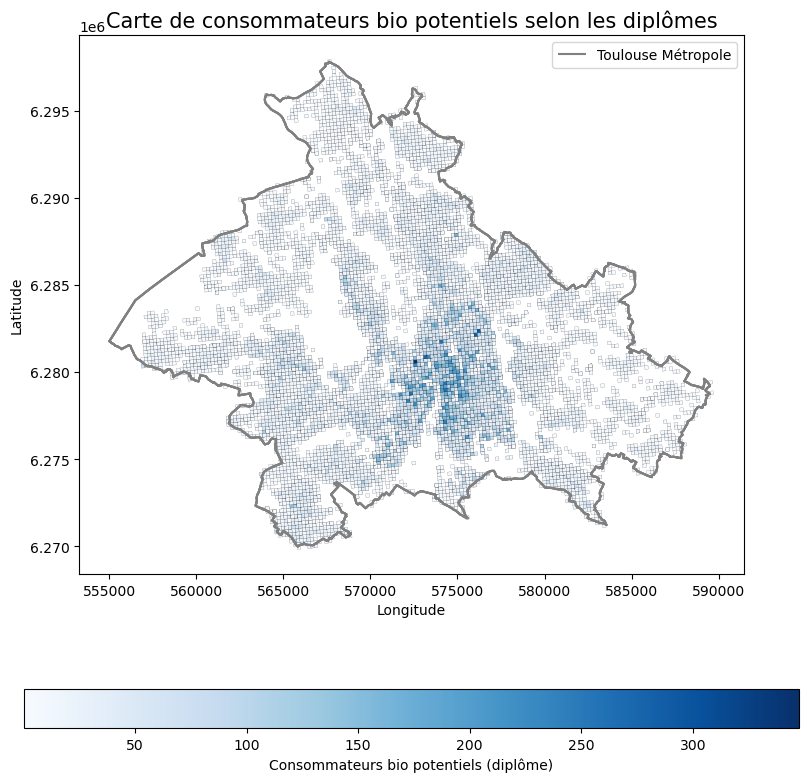

In [15]:
# Créer une figure et des axes
fig, ax = plt.subplots(figsize=(10, 10))

# Tracer les IRIS avec le score bio_potentiel_diplome
carte_heatmap_iris = carreaux_diplome.plot(column='potentiel_diplome', ax=ax, cmap='Blues', legend=True, 
                                       legend_kwds={'label': "Consommateurs bio potentiels (diplôme)", 'orientation': "horizontal"},
                                       edgecolor='black', linewidth=0.1)

# Superposer le périmètre de Toulouse Métropole
tls_mtp.boundary.plot(ax=ax, color='grey', linewidth=1.5, label='Toulouse Métropole')

# Ajouter un titre et ajuster l'affichage
plt.title("Carte de consommateurs bio potentiels selon les diplômes", fontsize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Afficher la légende et la carte
plt.legend(loc='upper right')
plt.show()

## **5. CSP**

In [16]:
# Charger les IRIS avec l'information sur les Catégorie SocioProfessionnelle (CSP)
iris_csp_brut = gpd.read_file(path_bd, layer='iris_csp')
iris_csp_brut.copy

# Vérifier les données
print(iris_csp_brut.columns)

Index(['CODE_IRIS', 'IRIS', 'actifs_csp+', 'actifs_csp=', 'actifs_csp-',
       'chomeurs', 'retraites', 'autres', 'geometry'],
      dtype='object')


In [17]:
#Changer le nom des colonnes
rename_csp = {'actifs_csp+' : 'actifs_csp_plus',
              'actifs_csp=' : 'actifs_csp_equal',
              'actifs_csp-' : 'actifs_csp_moins'}

iris_csp_brut = iris_csp_brut.rename(columns=rename_csp)
print(iris_csp_brut.columns)

Index(['CODE_IRIS', 'IRIS', 'actifs_csp_plus', 'actifs_csp_equal',
       'actifs_csp_moins', 'chomeurs', 'retraites', 'autres', 'geometry'],
      dtype='object')


In [18]:
# Faire la sommme de toute la population avec CSP
iris_csp_brut['total_csp'] = (
    iris_csp_brut['actifs_csp_plus'] +
    iris_csp_brut['actifs_csp_equal'] +
    iris_csp_brut['actifs_csp_moins'] +
    iris_csp_brut['chomeurs'] +
    iris_csp_brut['retraites'] +
    iris_csp_brut['autres']
)

In [19]:

# Calculer le pourcentange de personnes dans chaque CSP
iris_csp_brut['pct_actifs_csp_plus'] = iris_csp_brut['actifs_csp_plus'] / iris_csp_brut['total_csp'] * 100
iris_csp_brut['pct_actifs_csp_equal'] = iris_csp_brut['actifs_csp_equal'] / iris_csp_brut['total_csp'] * 100
iris_csp_brut['pct_actifs_csp_moins'] = iris_csp_brut['actifs_csp_moins'] / iris_csp_brut['total_csp'] * 100
iris_csp_brut['pct_chomeurs'] = iris_csp_brut['chomeurs'] / iris_csp_brut['total_csp'] * 100
iris_csp_brut['pct_retraites'] = iris_csp_brut['retraites'] / iris_csp_brut['total_csp'] * 100
iris_csp_brut['pct_autres'] = iris_csp_brut['autres'] / iris_csp_brut['total_csp'] * 100

# Regarder les nouvelles collonnes
print(iris_csp_brut.columns)

Index(['CODE_IRIS', 'IRIS', 'actifs_csp_plus', 'actifs_csp_equal',
       'actifs_csp_moins', 'chomeurs', 'retraites', 'autres', 'geometry',
       'total_csp', 'pct_actifs_csp_plus', 'pct_actifs_csp_equal',
       'pct_actifs_csp_moins', 'pct_chomeurs', 'pct_retraites', 'pct_autres'],
      dtype='object')


In [20]:
#Intersecter les carreaux avec les IRIS pour attribuer les valeurs de CSP aux carreaux
carreaux_csp = gpd.sjoin(carreaux_insee, iris_csp_brut, how='inner', predicate='intersects')

# Vérifier le résultat de la jointure pour s'assurer que les colonnes ont bien été combinées
carreaux_csp.head()

,idcar_200m,idcar_1km,idcar_nat,i_est_200,i_est_1km,lcog_geo,ind,men,men_pauv,men_1ind,...,chomeurs,retraites,autres,total_csp,pct_actifs_csp_plus,pct_actifs_csp_equal,pct_actifs_csp_moins,pct_chomeurs,pct_retraites,pct_autres
0,CRS3035RES200mN2307400E3638400,CRS3035RES1000mN2307000E3638000,CRS3035RES1000mN2307000E3638000,1,0,311693150631036,28.0,10.6,0.3,1.3,...,189.308800,897.101436,236.075922,3531.558487,24.199886,18.863442,19.489008,5.360489,25.402423,6.684752
0,CRS3035RES200mN2307400E3638400,CRS3035RES1000mN2307000E3638000,CRS3035RES1000mN2307000E3638000,1,0,311693150631036,28.0,10.6,0.3,1.3,...,54.101738,314.089060,155.787877,1295.917479,26.009962,18.542698,15.014312,4.174783,24.236810,12.021435
0,CRS3035RES200mN2307400E3638400,CRS3035RES1000mN2307000E3638000,CRS3035RES1000mN2307000E3638000,1,0,311693150631036,28.0,10.6,0.3,1.3,...,205.210676,786.579847,246.810991,3371.559766,13.892488,19.928459,29.442301,6.086520,23.329850,7.320380
1,CRS3035RES200mN2307600E3638000,CRS3035RES1000mN2307000E3638000,CRS3035RES1000mN2307000E3638000,1,0,3116931506,18.0,6.8,0.2,0.8,...,189.308800,897.101436,236.075922,3531.558487,24.199886,18.863442,19.489008,5.360489,25.402423,6.684752
1,CRS3035RES200mN2307600E3638000,CRS3035RES1000mN2307000E3638000,CRS3035RES1000mN2307000E3638000,1,0,3116931506,18.0,6.8,0.2,0.8,...,205.210676,786.579847,246.810991,3371.559766,13.892488,19.928459,29.442301,6.086520,23.329850,7.320380


In [21]:
# Calculer le nombre de personnes pour chaque CSP pour chaque carreau
# On applique les pourcentages chaque CSP du IRIS à la population active des carreaux.
carreaux_csp.loc[:, 'est_actifs_csp_plus'] = (
    carreaux_csp['pop_active'] * (carreaux_csp['pct_actifs_csp_plus'] / 100)
)
carreaux_csp.loc[:, 'est_actifs_csp_equal'] = (
    carreaux_csp['pop_active'] * (carreaux_csp['pct_actifs_csp_equal'] / 100)
)
carreaux_csp.loc[:, 'est_actifs_csp_moins'] = (
    carreaux_csp['pop_active'] * (carreaux_csp['pct_actifs_csp_moins'] / 100)
)
carreaux_csp.loc[:, 'est_chomeurs'] = (
    carreaux_csp['pop_active'] * (carreaux_csp['pct_chomeurs'] / 100)
)
carreaux_csp.loc[:, 'est_retraites'] = (
    carreaux_csp['pop_active'] * (carreaux_csp['pct_retraites'] / 100)
)
carreaux_csp.loc[:, 'est_autres'] = (
    carreaux_csp['pop_active'] * (carreaux_csp['pct_autres'] / 100)
)

In [22]:
# Vérifier les résultats après calculs
colonnes_csp = [
    'idcar_200m', 'pop_active', 'est_actifs_csp_plus', 'est_actifs_csp_equal', 'est_actifs_csp_moins',
    'est_chomeurs', 'est_retraites', 'est_autres', 'geometry'
]

# Créer un nouveau GeoDataFrame contenant uniquement les colonnes sélectionnées
carreaux_csp = carreaux_csp[colonnes_csp]

In [23]:
# Appliquer les pourcentages moyens pour estimer les consommateurs bio potentiels selon le CSP
# Chaque niveau de CSP a un pourcentage de consommation bio associé.
carreaux_csp = carreaux_csp.copy()  # Créer une copie pour éviter les warnings

carreaux_csp.loc[:, 'potentiel_csp'] = (
    carreaux_csp['est_actifs_csp_plus'] * 0.440 +   # Pourcentage pour les individus Actifs CSP + 
    carreaux_csp['est_actifs_csp_equal'] * 0.340 +            # Pourcentage pour les individus Actifs CSP = 
    carreaux_csp['est_actifs_csp_moins'] * 0.280 +                # Pourcentage pour les individus Actifs CSP -
    carreaux_csp['est_chomeurs'] * 0.220 +     # Pourcentage pour les individus avec dans le chômage
    carreaux_csp['est_retraites'] * 0.280 +                # Pourcentage pour les individus retraités
    carreaux_csp['est_autres'] * 0.260                # Pourcentage pour les individus inactifs
)

# Sélectionner les colonnes pertinentes et créer un nouveau GeoDataFrame
colonnes_csp_calc = ['idcar_200m', 'pop_active', 'potentiel_csp', 'geometry']
carreaux_csp = carreaux_csp[colonnes_csp_calc].copy()

# Vérifier la nouvelle structure du GeoDataFrame pour s'assurer que les colonnes sont correctes
print(carreaux_csp.head())
print(carreaux_csp.columns)


                       idcar_200m  pop_active  potentiel_csp  \
0  CRS3035RES200mN2307400E3638400        19.6       6.379499   
0  CRS3035RES200mN2307400E3638400        19.6       6.425515   
0  CRS3035RES200mN2307400E3638400        19.6       6.057754   
1  CRS3035RES200mN2307600E3638000        12.6       4.101106   
1  CRS3035RES200mN2307600E3638000        12.6       3.894270   

                                            geometry  
0  POLYGON ((583344.843 6271080.255, 583327.379 6...  
0  POLYGON ((583344.843 6271080.255, 583327.379 6...  
0  POLYGON ((583344.843 6271080.255, 583327.379 6...  
1  POLYGON ((582929.383 6271241.963, 582911.919 6...  
1  POLYGON ((582929.383 6271241.963, 582911.919 6...  
Index(['idcar_200m', 'pop_active', 'potentiel_csp', 'geometry'], dtype='object')


### **5.1 Plotter CSP**

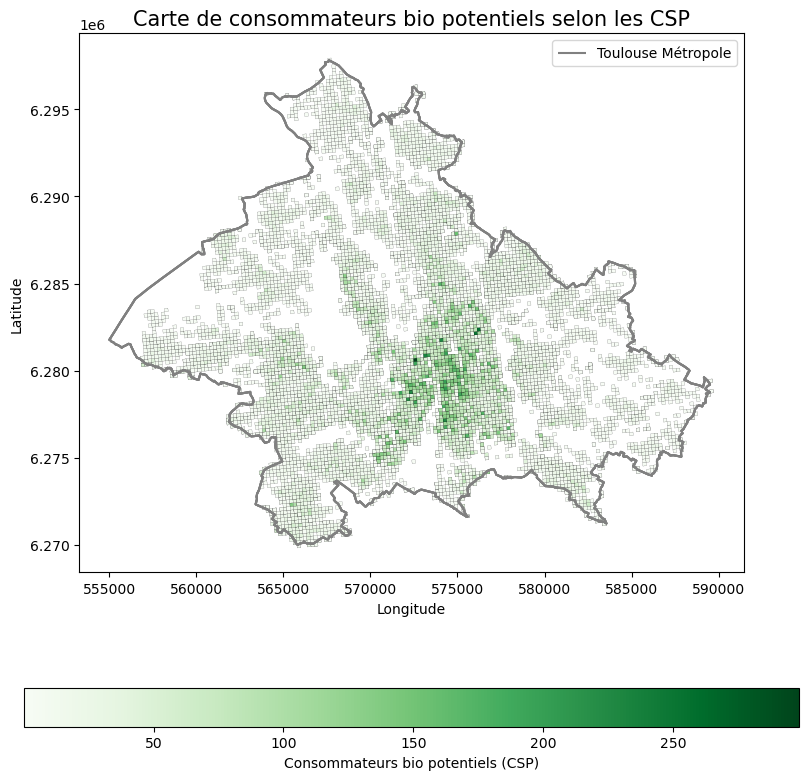

In [24]:
# Créer une figure et des axes
fig, ax = plt.subplots(figsize=(10, 10))

# Tracer les IRIS avec le score bio_potentiel_diplome
carte_heatmap_iris = carreaux_csp.plot(column='potentiel_csp', ax=ax, cmap='Greens', legend=True, 
                                       legend_kwds={'label': "Consommateurs bio potentiels (CSP)", 'orientation': "horizontal"},
                                       edgecolor='black', linewidth=0.1)

# Superposer le périmètre de Toulouse Métropole
tls_mtp.boundary.plot(ax=ax, color='grey', linewidth=1.5, label='Toulouse Métropole')

# Ajouter un titre et ajuster l'affichage
plt.title("Carte de consommateurs bio potentiels selon les CSP", fontsize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Afficher la légende et la carte
plt.legend(loc='upper right')
plt.show()

## **6. Enregistrer consommateurs.gpkg** 

In [25]:
# Définir le chemin vers le fichier GeoPackage où tous les vecteurs seront sauvegardés
gpkg_output = os.path.join('../data_final', 'emc_tls.gpkg')

# Fonction pour sauvegarder un GeoDataFrame dans un GeoPackage avec un nom de couche spécifié
def sauver_gpkg(geodataframe, nom_couche, chemin_gpkg):
    """
    Sauvegarde un GeoDataFrame dans un fichier GeoPackage (.gpkg)
    
    geodataframe: Le GeoDataFrame à sauvegarder
    nom_couche: Nom de la couche dans le GPKG
    chemin_gpkg: Chemin complet vers le fichier GeoPackage
    """
    geodataframe.to_file(chemin_gpkg, layer=nom_couche, driver="GPKG")
    print(f'Couche "{nom_couche}" sauvegardée dans le GeoPackage: {chemin_gpkg}')

# Sauvegarder les GeoDataFrames concernant l'âge, le revenu, les diplômes et le CSP
sauver_gpkg(carreaux_age, 'potentiel_age', gpkg_output)
sauver_gpkg(carreaux_revenu, 'potentiel_revenu', gpkg_output)
sauver_gpkg(carreaux_diplome, 'potentiel_diplome', gpkg_output)
sauver_gpkg(carreaux_csp, 'potentiel_csp', gpkg_output)


Couche "potentiel_age" sauvegardée dans le GeoPackage: ../data_final\emc_tls.gpkg
Couche "potentiel_revenu" sauvegardée dans le GeoPackage: ../data_final\emc_tls.gpkg
Couche "potentiel_diplome" sauvegardée dans le GeoPackage: ../data_final\emc_tls.gpkg
Couche "potentiel_csp" sauvegardée dans le GeoPackage: ../data_final\emc_tls.gpkg


## **7. Rastérization des indicateurs socio-économiques et de la surface d'eau**

### **7.1 Paramètres**

In [26]:
# Charger les deux couches
plan_deau = gpd.read_file(path_bd, layer='plan_d_eau')
surface_deau = gpd.read_file(path_bd, layer='surface_hydrographique')

# # Concaténer les deux couches en un seul GeoDataFrame
eau_merged = gpd.GeoDataFrame(pd.concat([plan_deau, surface_deau], ignore_index=True))
eau_merged = eau_merged[['cleabs', 'geometry']]

# Vérifier le résultat
print(eau_merged.head())
eau_merged.info()

                     cleabs                                           geometry
0  PLANDEAU0000002000780755  MULTIPOLYGON (((569066.3 6295437.4, 569068.4 6...
1  PLANDEAU0000002000780778  MULTIPOLYGON (((565176.7 6286417.8, 565175.8 6...
2  PLANDEAU0000002000780780  MULTIPOLYGON (((563540.3 6287469.9, 563543.1 6...
3  PLANDEAU0000002000779875  MULTIPOLYGON (((586897.4 6279869.2, 586900.3 6...
4  PLANDEAU0000002000780679  MULTIPOLYGON (((568663.4 6288560.9, 568650.7 6...
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 934 entries, 0 to 933
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   cleabs    934 non-null    object  
 1   geometry  934 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 14.7+ KB


In [27]:
# Définir la résolution souhaitée pour le raster (200m)
resolution = 200  # Resolution pour masquer avec les distances de l'infrastructure

# Définir la fenêtre d'étendue pour le raster (même étendue que Toulouse Métropole)
bounds = tls_mtp.total_bounds  # Obtenir l'étendue de la zone

# Définir les dimensions du raster en fonction des limites et de la résolution
width = int((bounds[2] - bounds[0]) / resolution)  # Largeur du raster en fonction de l'étendue
height = int((bounds[3] - bounds[1]) / resolution)  # Hauteur du raster en fonction de l'étendue

### **7.2 Fonction pour la rastérisation**

In [28]:
def rasteriser_gdf(geodataframe, colonne_valeur, output_file):
    """
    Fonction pour rasteriser un GeoDataFrame en utilisant une colonne de valeurs spécifique
    et enregistrer le résultat en tant que fichier raster compressé.

    Parameters:
    - geodataframe: Le GeoDataFrame contenant les géométries à rasteriser.
    - colonne_valeur: La colonne du GeoDataFrame contenant les valeurs à attribuer aux pixels.
    - output_file: Le chemin du fichier où le raster sera sauvegardé.

    """

    # Définir la transformation spatiale en fonction des limites géographiques et de la résolution
    transform = rasterio.transform.from_bounds(*bounds, width=width, height=height)

    # Rasteriser les géométries en attribuant la valeur de la colonne spécifiée
    raster = rasterize(
        [(geom, value) for geom, value in zip(geodataframe.geometry, geodataframe[colonne_valeur])],
        out_shape=(height, width),  # Dimensions du raster en sortie
        transform=transform,         # Transformation spatiale pour aligner les pixels aux coordonnées
        fill=-9999,                  # Valeur pour les pixels sans données
        dtype='float32'              # Type de données des valeurs des pixels
    )

    # Options pour la compression LZW du fichier raster
    compress_options = {
        'compress': 'LZW',           # Appliquer la compression LZW
        'predictor': 3,              # Utiliser un prédicteur pour améliorer la compression
        'tiled': True,               # Format en tuiles pour une meilleure performance
        'blockxsize': 256,           # Taille des blocs pour chaque tuile en X
        'blockysize': 256            # Taille des blocs pour chaque tuile en Y
    }

    # Enregistrer le raster avec la compression LZW appliquée
    with rasterio.open(
        output_file, 'w', driver='GTiff', height=height, width=width,
        count=1, dtype='float32', crs=geodataframe.crs,
        transform=transform, nodata=-9999, **compress_options
    ) as dst:
        dst.write(raster, 1)  # Écrire les valeurs rasterisées dans la première bande

    print(f"Raster {output_file} sauvegardé avec compression LZW.")


In [29]:
# Rasteriser les carreaux de revenu
rasteriser_gdf(carreaux_revenu, 'potentiel_revenu', f'{partial_output_path}/revenu_abs.tif')

# Rasteriser les carreaux d'âge
rasteriser_gdf(carreaux_age, 'potentiel_age', f'{partial_output_path}/age_abs.tif')

# Rasteriser le GeoDataFrame des IRIS (diplômes)
rasteriser_gdf(carreaux_diplome, 'potentiel_diplome', f'{partial_output_path}/diplome_abs.tif')

# Rasteriser le GeoDataFrame des IRIS (CSP)
rasteriser_gdf(carreaux_csp, 'potentiel_csp', f'{partial_output_path}/csp_abs.tif')

Raster ../data_brut/2_rasters/revenu_abs.tif sauvegardé avec compression LZW.
Raster ../data_brut/2_rasters/age_abs.tif sauvegardé avec compression LZW.
Raster ../data_brut/2_rasters/diplome_abs.tif sauvegardé avec compression LZW.
Raster ../data_brut/2_rasters/csp_abs.tif sauvegardé avec compression LZW.


In [30]:
# Rasteriser le GeoDataFrame des surfaces d'eau
rasteriser_gdf(eau_merged, 'cleabs', f'{partial_output_path}/eau_merged.tif')

Raster ../data_brut/2_rasters/eau_merged.tif sauvegardé avec compression LZW.


## **8. Calcul de distance**

In [31]:
# Charger les couches de lignes et de Tls Métropole
pistes_cyclables = gpd.read_file(path_bd, layer='route_cyclabe_geovelo')
routes_nommee = gpd.read_file(path_bd, layer='route_numerotee_ou_nommee')

In [32]:
# Obtenir l'emprise du département
minx, miny, maxx, maxy = tls_mtp.total_bounds

## **8.1. Fonction pour calculer les distances**

In [33]:
def calculate_distance(layer, mask_layer, output_name, resolution):
    # Calculer la taille du raster en fonction de la résolution
    n_cols = int(np.ceil((maxx - minx) / resolution))
    n_rows = int(np.ceil((maxy - miny) / resolution))
    transform = from_origin(minx, maxy, resolution, resolution)
    raster_shape = (n_rows, n_cols)
    
    # Rasteriser la couche de lignes
    shapes = ((geom, 1) for geom in layer.geometry)
    rasterized = features.rasterize(
        shapes=shapes,
        out_shape=raster_shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype=np.uint8
    )
    
    # Calcul de la distance
    distance = ndimage.distance_transform_edt(1 - rasterized) * resolution
    distance = distance.astype('float32')
    
    # Appliquer le masque du département
    shapes_mask = ((geom, 1) for geom in mask_layer.geometry)
    raster_mask = features.rasterize(
        shapes=shapes_mask,
        out_shape=raster_shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype=np.uint8
    )
    distance_masked = np.where(raster_mask == 1, distance, np.nan)
    
    # Enregistrer le raster avec compression LZW
    output_filepath = os.path.join(partial_output_path, output_name)
    compress_options = {
        'compress': 'LZW',
        'predictor': 3,
        'tiled': True,
        'blockxsize': 256,
        'blockysize': 256
    }
    
    with rasterio.open(
        output_filepath,
        'w',
        driver='GTiff',
        height=n_rows,
        width=n_cols,
        count=1,
        dtype='float32',
        crs=layer.crs,
        transform=transform,
        nodata=np.nan,
        **compress_options
    ) as dst:
        dst.write(distance_masked, 1)
    print(f"Le raster est enregistré à l'emplacement : {output_filepath}")

### **8.2 Calculer les distances et sauvegarder les rasters**

In [34]:
# Calculer et sauvegarder les rasters avec la résolution spécifiée
calculate_distance(pistes_cyclables, tls_mtp, 'dist_pistes_cyclables_abs.tif', resolution=5)
calculate_distance(routes_nommee, tls_mtp, 'dist_routes_nommee_abs.tif', resolution=5)

Le raster est enregistré à l'emplacement : ../data_brut/2_rasters\dist_pistes_cyclables_abs.tif
Le raster est enregistré à l'emplacement : ../data_brut/2_rasters\dist_routes_nommee_abs.tif


## **9. Reéchantillonnage des rasters**

In [35]:
def resampling(input_file, raster_ref, output_file):
    # Ouvrir le raster d'entrée et le raster de référence
    with rasterio.open(input_file) as src, rasterio.open(raster_ref) as ref:
        # Calculer la transformation cible et la résolution en fonction du raster de référence
        transform, width, height = calculate_default_transform(
            src.crs, ref.crs, ref.width, ref.height, *ref.bounds
        )
        
        # Copier les métadonnées du raster d'entrée pour les adapter au raster de sortie
        profile = src.profile
        profile.update({
            'crs': ref.crs,         # Utiliser le système de coordonnées du raster de référence
            'transform': transform, # Transformation du raster pour correspondre aux dimensions et à l'étendue
            'width': width,         # Nouvelle largeur du raster
            'height': height,       # Nouvelle hauteur du raster
            'nodata': np.nan,       # Définir NaN comme valeur pour les données manquantes
            'dtype': 'float32'      # Définir le type de données en sortie
        })
        
        # Options de compression LZW
        compress_options = {
            'compress': 'LZW',       # Appliquer la compression LZW
            'predictor': 3,          # Optimiser la compression avec un prédicteur
            'tiled': True,           # Utiliser un format en tuiles pour de meilleures performances
            'blockxsize': 256,       # Taille des blocs pour chaque tuile en X
            'blockysize': 256        # Taille des blocs pour chaque tuile en Y
        }
        profile.update(**compress_options)

        # Reéchantillonner et sauvegarder le raster aligné
        with rasterio.open(output_file, 'w', **profile) as dst:
            reproject(
                source=rasterio.band(src, 1),       # Source : première bande du raster d'entrée
                destination=rasterio.band(dst, 1),  # Destination : première bande du raster de sortie
                src_transform=src.transform,        # Transformation du raster d'entrée
                src_crs=src.crs,                    # Système de coordonnées du raster d'entrée
                dst_transform=transform,            # Transformation du raster de sortie
                dst_crs=ref.crs,                    # Système de coordonnées du raster de référence
                resampling=Resampling.bilinear      # Méthode de rééchantillonnage bilinéaire pour lisser les données
            )
    print(f"Raster reéchantillonné {output_file} sauvegardé.")


In [36]:
# Rééchantillonner les rasters socioéconomiques et de distance pour l'alignement
resampling(f'{partial_output_path}/age_abs.tif', f'{partial_output_path}/dist_pistes_cyclables_abs.tif', f'{partial_output_path}/age_rsp.tif')
resampling(f'{partial_output_path}/revenu_abs.tif', f'{partial_output_path}/dist_pistes_cyclables_abs.tif', f'{partial_output_path}/revenu_rsp.tif')
resampling(f'{partial_output_path}/diplome_abs.tif', f'{partial_output_path}/dist_pistes_cyclables_abs.tif', f'{partial_output_path}/diplome_rsp.tif')
resampling(f'{partial_output_path}/csp_abs.tif', f'{partial_output_path}/dist_pistes_cyclables_abs.tif', f'{partial_output_path}/csp_rsp.tif')


Raster reéchantillonné ../data_brut/2_rasters/age_rsp.tif sauvegardé.
Raster reéchantillonné ../data_brut/2_rasters/revenu_rsp.tif sauvegardé.
Raster reéchantillonné ../data_brut/2_rasters/diplome_rsp.tif sauvegardé.
Raster reéchantillonné ../data_brut/2_rasters/csp_rsp.tif sauvegardé.


In [37]:
# Rééchantillonner le raster de surface d'eau
resampling(f'{partial_output_path}/eau_merged.tif', f'{partial_output_path}/dist_pistes_cyclables_abs.tif', f'{partial_output_path}/eau_merged_rsp.tif')

Raster reéchantillonné ../data_brut/2_rasters/eau_merged_rsp.tif sauvegardé.


## **10. Masquage des rasters**

### **10.1 Créer la masque combiné des carreaux et de surface d'eau**

In [38]:
def create_masks(raster_age, raster_eau, output_mask_age_file, output_mask_eau_file, output_combined_mask_file):
    """
    Crée trois masques binaires :
    1. Masque uniquement basé sur le raster d'âge.
    2. Masque uniquement basé sur le raster d'eau.
    3. Masque combiné excluant les zones d'eau.

    raster_age : Chemin vers le raster d'âge (ex: age_rsp.tif)
    raster_eau : Chemin vers le raster d'eau (ex: eau_merged_rsp.tif)
    output_mask_age_file : Chemin pour sauvegarder le masque basé sur le raster d'âge
    output_mask_eau_file : Chemin pour sauvegarder le masque basé sur le raster d'eau
    output_combined_mask_file : Chemin pour sauvegarder le masque combiné
    """
    with rasterio.open(raster_age) as src_age, rasterio.open(raster_eau) as src_eau:
        # Lire les données des deux rasters
        data_age = src_age.read(1)
        data_eau = src_eau.read(1)

        # Créer la masque pour l'âge uniquement
        mask_age = np.where(~np.isnan(data_age), 1, 0).astype('uint8')

        # Créer la masque pour l'eau uniquement
        mask_eau = np.where(~np.isnan(data_eau), 1, 0).astype('uint8')

        # Créer le masque combiné (âge sans eau)
        mask_combined = np.where((~np.isnan(data_age)) & (np.isnan(data_eau)), 1, 0).astype('uint8')

        # Profil commun pour les trois masques
        profile = src_age.profile
        profile.update({
            'dtype': 'uint8',       # Type de données pour un masque binaire
            'nodata': 0,            # 0 représente l'absence de données
            'compress': 'LZW',      # Compression LZW
            'predictor': 2,         # Optimisation de la compression
            'tiled': True,          # Format en tuiles
            'blockxsize': 256,      # Taille de bloc X pour les tuiles
            'blockysize': 256       # Taille de bloc Y pour les tuiles
        })

        # Sauvegarder chaque masque
        with rasterio.open(output_mask_age_file, 'w', **profile) as dst:
            dst.write(mask_age, 1)
        print(f"Masque basé sur l'âge sauvegardé : {output_mask_age_file}")

        with rasterio.open(output_mask_eau_file, 'w', **profile) as dst:
            dst.write(mask_eau, 1)
        print(f"Masque basé sur l'eau sauvegardé : {output_mask_eau_file}")

        with rasterio.open(output_combined_mask_file, 'w', **profile) as dst:
            dst.write(mask_combined, 1)
        print(f"Masque combiné sauvegardé : {output_combined_mask_file}")


In [40]:
# Créer les trois masques
create_masks(
    f'{partial_output_path}/age_rsp.tif',
    f'{partial_output_path}/eau_merged_rsp.tif',
    f'{partial_output_path}/mask_carreaux.tif',      # Masque uniquement pour age_rsp
    f'{partial_output_path}/mask_eau.tif',      # Masque uniquement pour eau
    f'{partial_output_path}/mask_combined.tif'  # Masque combiné
)


Masque basé sur l'âge sauvegardé : ../data_brut/2_rasters/mask_carreaux.tif
Masque basé sur l'eau sauvegardé : ../data_brut/2_rasters/mask_eau.tif
Masque combiné sauvegardé : ../data_brut/2_rasters/mask_combined.tif


In [91]:
def appliquer_masque(input_file, mask_file, output_file):
    """
    Applique un masque combiné à un raster et sauvegarde le résultat avec compression LZW.
    
    input_file : Chemin du raster d'entrée
    mask_file : Chemin du fichier de masque binaire pour la zone d'intérêt
    output_file : Chemin pour sauvegarder le raster masqué
    """
    # Charger les données du raster d'entrée
    with rasterio.open(input_file) as src:
        data = src.read(1)
        profile = src.profile

    # Charger les données du masque binaire
    with rasterio.open(mask_file) as mask_src:
        mask_data = mask_src.read(1)

    # Applique le masque uniquement où les pixels du masque sont égaux à 1
    data_masque = np.where(mask_data == 1, data, -9999)

    # Met à jour le profil pour définir NoData et ajouter la compression LZW
    profile.update(
        nodata=-9999,
        compress='LZW',
        predictor=3,
        tiled=True,
        blockxsize=256,
        blockysize=256
    )

    # Sauvegarder le raster avec le masque appliqué
    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(data_masque, 1)

    print(f"Raster masqué sauvegardé: {output_file}")


In [92]:
# Masquer les rasters rééchantillonnés
appliquer_masque(f'{partial_output_path}/age_rsp.tif', f'{partial_output_path}/mask_combined.tif', f'{partial_output_path}/age_masque.tif')
appliquer_masque(f'{partial_output_path}/revenu_rsp.tif', f'{partial_output_path}/mask_combined.tif', f'{partial_output_path}/revenu_masque.tif')
appliquer_masque(f'{partial_output_path}/diplome_rsp.tif', f'{partial_output_path}/mask_combined.tif', f'{partial_output_path}/diplome_masque.tif')
appliquer_masque(f'{partial_output_path}/csp_rsp.tif', f'{partial_output_path}/mask_combined.tif', f'{partial_output_path}/csp_masque.tif')
appliquer_masque(f'{partial_output_path}/dist_pistes_cyclables_abs.tif', f'{partial_output_path}/mask_combined.tif', f'{partial_output_path}/dist_pistes_cyclable_masque.tif')
appliquer_masque(f'{partial_output_path}/dist_routes_nommee_abs.tif', f'{partial_output_path}/mask_combined.tif', f'{partial_output_path}/dist_routes_nommee_masque.tif')

Raster masqué sauvegardé: ../data_brut/2_rasters/age_masque.tif
Raster masqué sauvegardé: ../data_brut/2_rasters/revenu_masque.tif
Raster masqué sauvegardé: ../data_brut/2_rasters/diplome_masque.tif
Raster masqué sauvegardé: ../data_brut/2_rasters/csp_masque.tif
Raster masqué sauvegardé: ../data_brut/2_rasters/dist_pistes_cyclable_masque.tif
Raster masqué sauvegardé: ../data_brut/2_rasters/dist_routes_nommee_masque.tif


## **11. Normalisátion des rasters**

In [93]:
def normaliser_raster(input_file, output_file, inverser=False):
    """
    Normalise un raster en définissant NaN pour NoData, applique une compression LZW, 
    et enregistre le résultat. Inverse les valeurs si nécessaire.
    
    input_file : Chemin du raster d'entrée
    output_file : Chemin du raster normalisé
    inverser : Si True, inverse les valeurs normalisées (1 - valeur)
    """
    with rasterio.open(input_file) as src:
        data = src.read(1)
        
        # Remplace NoData par NaN pour ignorer ces valeurs dans les calculs
        if src.nodata is not None:
            data[data == src.nodata] = np.nan

        # Normalise les données entre 0 et 1, si elles ne sont pas toutes NaN
        if not np.isnan(data).all():
            min_val, max_val = np.nanmin(data), np.nanmax(data)
            print(f"Valeur minimale: {min_val}, Valeur maximale: {max_val}")  # Diagnostique

            # Normalisation
            if min_val != max_val:
                normalized_data = (data - min_val) / (max_val - min_val)
            else:
                normalized_data = np.zeros_like(data)  # Cas où tous les valeurs sont identiques

            # Inverser les valeurs si nécessaire
            if inverser:
                normalized_data = 1 - normalized_data
                print("Inversion appliquée aux valeurs normalisées.")

            # Vérifier les valeurs normalisées
            print(f"Intervalle des données normalisées: {np.nanmin(normalized_data)} à {np.nanmax(normalized_data)}")

            # Met à jour le profil pour NaN comme NoData et ajoute la compression LZW
            profile = src.profile
            profile.update(dtype='float32', nodata=np.nan, compress='LZW')

            # Sauvegarde le raster normalisé avec compression
            with rasterio.open(output_file, 'w', **profile) as dst:
                dst.write(normalized_data, 1)
            
            print(f"Raster normalisé sauvegardé: {output_file}")


In [94]:
# Normaliser les raster
normaliser_raster(f'{partial_output_path}/age_masque.tif', f'{final_output_path}/age_norm.tif')
normaliser_raster(f'{partial_output_path}/revenu_masque.tif', f'{final_output_path}/revenu_norm.tif')
normaliser_raster(f'{partial_output_path}/diplome_masque.tif', f'{final_output_path}/diplome_norm.tif')
normaliser_raster(f'{partial_output_path}/csp_masque.tif', f'{final_output_path}/csp_norm.tif')
normaliser_raster(f'{partial_output_path}/dist_pistes_cyclable_masque.tif', f'{final_output_path}/dist_pistes_cyclable_norm.tif', inverser=True)
normaliser_raster(f'{partial_output_path}/dist_routes_nommee_masque.tif', f'{final_output_path}/dist_routes_nommee_norm.tif', inverser=True)
normaliser_raster(f'{partial_output_path}/dist_pistes_cyclable_masque.tif', f'{final_output_path}/dist_pistes_cyclable_norm_affichage.tif', inverser=False)
normaliser_raster(f'{partial_output_path}/dist_routes_nommee_masque.tif', f'{final_output_path}/dist_routes_nommee_norm_affichage.tif', inverser=False)

Valeur minimale: 0.19200000166893005, Valeur maximale: 323.5902099609375
Intervalle des données normalisées: 0.0 à 1.0
Raster normalisé sauvegardé: ../data_final/age_norm.tif
Valeur minimale: 0.2800000011920929, Valeur maximale: 461.7156677246094
Intervalle des données normalisées: 0.0 à 1.0
Raster normalisé sauvegardé: ../data_final/revenu_norm.tif
Valeur minimale: 0.1116216629743576, Valeur maximale: 343.14837646484375
Intervalle des données normalisées: 0.0 à 1.0
Raster normalisé sauvegardé: ../data_final/diplome_norm.tif
Valeur minimale: 0.09743820130825043, Valeur maximale: 294.6021423339844
Intervalle des données normalisées: 0.0 à 1.0
Raster normalisé sauvegardé: ../data_final/csp_norm.tif
Valeur minimale: 0.0, Valeur maximale: 4060.997314453125
Inversion appliquée aux valeurs normalisées.
Intervalle des données normalisées: 0.0 à 1.0
Raster normalisé sauvegardé: ../data_final/dist_pistes_cyclable_norm.tif
Valeur minimale: 0.0, Valeur maximale: 3056.0185546875
Inversion appliqué

## **12. Vérifier les rasters**

In [95]:
# Chemins des rasters à vérifier
rasters = [
    os.path.join(final_output_path, 'age_norm.tif'),
    os.path.join(final_output_path, 'revenu_norm.tif'),
    os.path.join(final_output_path, 'diplome_norm.tif'),
    os.path.join(final_output_path, 'csp_norm.tif'),
    os.path.join(final_output_path, 'dist_pistes_cyclable_norm.tif'),
    os.path.join(final_output_path, 'dist_routes_nommee_norm.tif')
]

In [96]:
def verifier_raster(raster_path):
    """
    Fonction pour vérifier les informations sur le raster, y compris le comptage des valeurs NoData et les statistiques min, max, moyenne.
    """
    with rasterio.open(raster_path) as src:
        print(f"=== Vérification du Raster: {raster_path} ===")
        print(f"Nombre de bandes: {src.count}")
        print(f"Valeur NoData: {src.nodata}")
        print(f"Résolution: {src.res}")
        print(f"Projection (CRS): {src.crs}")
        
        # Parcourir chaque bande
        for i in range(1, src.count + 1):
            bande = src.read(i).astype(float)  # Conversion en float pour gérer NaN
            nodata_valeur = src.nodata if src.nodata is not None else np.nan
            bande[bande == nodata_valeur] = np.nan  # Remplace NoData par NaN

            # Compter les pixels NoData et valides
            nodata_count = np.isnan(bande).sum()
            valide_count = np.count_nonzero(~np.isnan(bande))
            
            # Afficher les résultats de la bande
            print(f"--- Bande {i} ---")
            print(f"  Pixels NoData: {nodata_count}")
            print(f"  Pixels valides: {valide_count}")
            
            # Calculer les statistiques si des données valides existent
            if valide_count > 0:
                print(f"  Min: {np.nanmin(bande)}")
                print(f"  Max: {np.nanmax(bande)}")
                print(f"  Moyenne: {np.nanmean(bande)}")
            else:
                print(f"  Bande {i} contient uniquement des valeurs NoData.")
        
        print("="*40)

In [97]:
# Vérifier les statistiques et NoData pour chaque raster
for raster in rasters:
    verifier_raster(raster)    

=== Vérification du Raster: ../data_final\age_norm.tif ===
Nombre de bandes: 1
Valeur NoData: nan
Résolution: (5.0, 5.0)
Projection (CRS): EPSG:2154
--- Bande 1 ---
  Pixels NoData: 27283261
  Pixels valides: 11142839
  Min: 0.0
  Max: 1.0
  Moyenne: 0.08030328729203645
=== Vérification du Raster: ../data_final\revenu_norm.tif ===
Nombre de bandes: 1
Valeur NoData: nan
Résolution: (5.0, 5.0)
Projection (CRS): EPSG:2154
--- Bande 1 ---
  Pixels NoData: 27283261
  Pixels valides: 11142839
  Min: 0.0
  Max: 1.0
  Moyenne: 0.08079284332004572
=== Vérification du Raster: ../data_final\diplome_norm.tif ===
Nombre de bandes: 1
Valeur NoData: nan
Résolution: (5.0, 5.0)
Projection (CRS): EPSG:2154
--- Bande 1 ---
  Pixels NoData: 27292941
  Pixels valides: 11133159
  Min: 0.0
  Max: 1.0
  Moyenne: 0.06866985780864733
=== Vérification du Raster: ../data_final\csp_norm.tif ===
Nombre de bandes: 1
Valeur NoData: nan
Résolution: (5.0, 5.0)
Projection (CRS): EPSG:2154
--- Bande 1 ---
  Pixels NoData